In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, validation_curve, cross_val_score, train_test_split, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

!wandb login bba1e1fa6dcd5919bf34e3094e5632c056b0c4d6
import wandb
from wandb.xgboost import wandb_callback
wandb.init(project="dslab-kaggle")

%matplotlib inline

wandb: Appending key for api.wandb.ai to your netrc file: /Users/maxdauber/.netrc


wandb: Currently logged in as: maxdauber (use `wandb login --relogin` to force relogin)


#### Load in Housing Data

In [2]:
train = pd.read_csv('data-science-comp-f2020/train_final.csv').iloc[:,1:-1]
test = pd.read_csv('data-science-comp-f2020/test_final.csv').iloc[:,1:-1]
y = pd.DataFrame(train.Y)
train = train.drop(columns="Y")
train.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23
0,25884,1,33.63,118596,1,0,118595,125738,1,3,...,-2.266430,1945,118450,119184,1,121372,1,1,1,2
1,34346,1,10.62,118041,1,0,117902,130913,1,1,...,-0.305612,15385,117945,292795,1,259173,1,1,1,1
2,34923,1,1.77,118327,1,0,117961,124402,1,2,...,2.015561,7547,118933,290919,1,118784,1,1,1,1
3,80926,1,30.09,118300,1,0,117961,301218,1,0,...,-3.172501,4933,118458,118331,1,307024,1,1,1,2
4,4674,1,1.77,119921,1,0,119920,302830,1,0,...,0.573767,13836,142145,4673,1,128230,1,1,1,620


In [3]:
#Samples from both train and test
all_data = pd.concat((train.iloc[:,1:-1],
                      test.iloc[:,1:-1]))

#### Useful functions for below

In [5]:
global model_counter
model_counter = 0
def export_test(preds, model, params):
    global model_counter
    model_counter += 1
    model_name = datetime.today().strftime('%Y_%m_%d') + "xgboost_" + str(model_counter)
    model.save_model(f'models/{model_name}.model')
    
    model_params = f"models/{model_name}_params.json"
    with open(model_params, 'w') as fp:
        json.dump(params, fp)
        
    ids = pd.read_csv('data-science-comp-f2020/test_final.csv').iloc[:,0]
    np.shape(ids)
    temp = pd.concat([ids, preds], axis=1)
    temp.to_csv(f'results/{model_name}.csv',index=False,header=True)
    print("Saved model:", model_name)

#### Brief Data Exploration

In [6]:
train.describe()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23
count,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,...,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,1.638300e+04
mean,43007.775865,1.044375,11.770938,118323.581456,1.044436,0.050052,117089.674113,169730.178600,1.041812,4.976317,...,0.293940,25894.316914,119045.099005,184622.040835,1.047305,125959.667765,1.044558,1.045718,1.041934,3.271890e+04
std,33611.182771,0.264806,353.187115,4518.059755,0.265601,0.293892,10261.292970,69396.677853,0.258226,65.629620,...,1.728999,36086.993946,18321.987129,100590.811845,0.306239,31091.344158,0.262576,0.266874,0.246597,3.184929e+06
min,-1.000000,1.000000,1.770000,23779.000000,1.000000,0.000000,4292.000000,4673.000000,1.000000,0.000000,...,-7.446045,25.000000,4674.000000,3130.000000,1.000000,117879.000000,1.000000,1.000000,1.000000,1.000000e+00
25%,20311.000000,1.000000,1.770000,118096.000000,1.000000,0.000000,117961.000000,117906.000000,1.000000,0.000000,...,-0.704562,4554.000000,118395.000000,118398.000000,1.000000,118274.000000,1.000000,1.000000,1.000000,1.000000e+00
50%,35527.000000,1.000000,1.770000,118300.000000,1.000000,0.000000,117961.000000,128130.000000,1.000000,0.000000,...,1.000000,13234.000000,118929.000000,119095.000000,1.000000,118568.000000,1.000000,1.000000,1.000000,2.000000e+00
75%,74240.500000,1.000000,3.540000,118386.000000,1.000000,0.000000,117961.000000,234498.500000,1.000000,1.000000,...,1.000000,38902.000000,120539.000000,290919.000000,1.000000,120006.000000,1.000000,1.000000,1.000000,9.000000e+00
max,312152.000000,7.000000,43910.160000,286791.000000,9.000000,10.000000,311178.000000,311867.000000,11.000000,5036.000000,...,7.398682,311696.000000,286792.000000,308574.000000,18.000000,311867.000000,8.000000,8.000000,7.000000,4.042886e+08


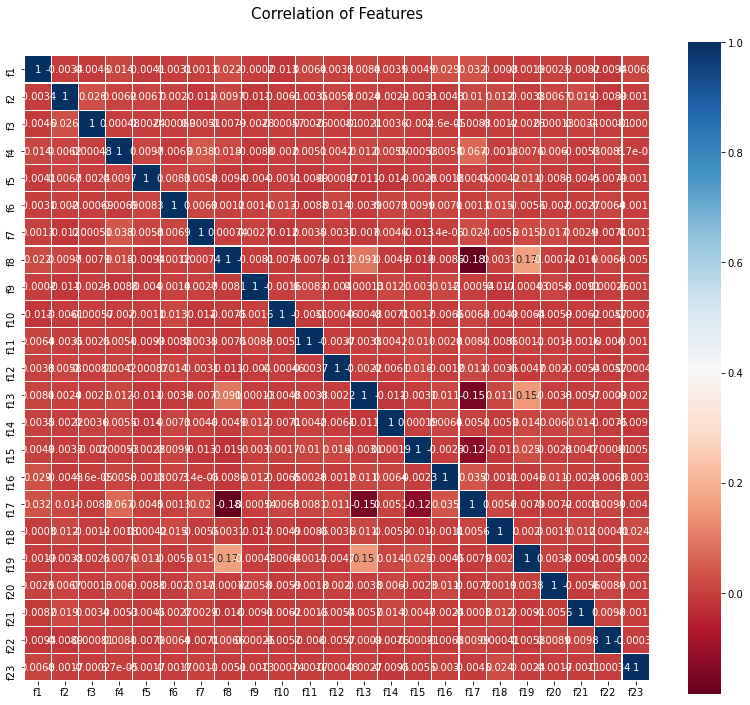

In [7]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

We can see the distribution of binary values in the train set

In [8]:
counts = y['Y'].value_counts()
print(counts)

1    15435
0      948
Name: Y, dtype: int64


# Training Models

### Trying XGBoost
First attempt is just vanilla, no tuning

In [9]:
X_train, X_test, y_train, y_test = train_test_split(train,y,test_size=.2, random_state=42)
if "Y" in X_train.columns:
    del data["Y"]
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
dtest_submit = xgb.DMatrix(test)
params = {
    'eta': 0.1, 
    'max_depth': 20,  
    'objective': 'multi:softprob',  
    'num_class': 2, 
    'verbosity':1} 

steps = 20
num_round = 10

In [10]:
model = xgb.train(params, dtrain, steps)

In [11]:
soft_preds = pd.DataFrame(model.predict(dtest))
soft_preds_result = pd.DataFrame(model.predict(dtest)).iloc[:, 1:]
soft_preds_result.columns = ["Y"]
soft_preds_result.head()

,Y
0,0.929146
1,0.688694
2,0.528397
3,0.934351
4,0.916486


In [12]:
model_counter

0

In [13]:
export_test(soft_preds, model, params)

Saved model: 2020_10_25xgboost_1


Trying submission with hard predictions

In [ ]:
hard_preds = pd.DataFrame([np.argmax(line) for line in soft_preds])
hard_preds.columns = ["Y"]
np.shape(hard_preds)

In [ ]:
export_test(soft_preds_result, model, params)

### Trying out Cross Validation
Instantiate training datasets and base params

In [14]:
X_train, X_test, y_train, y_test = train_test_split(train,y,test_size=.2, random_state=42)
if "Y" in X_train.columns:
    del data["Y"]
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
dtest_submit = xgb.DMatrix(test)
params = {
    'learning_rate': 0.1, 
    'colsample_bytree': 0.3,
    'max_depth': 20,  
    'objective': 'multi:softprob',  
    'num_class': 2, 
    'eval_metric': 'mlogloss',
    'alpha': 10,
    'verbosity':1} 
evals = [(dtest,'eval'), (dtrain,'train')]
steps = 20
num_round = 10

In [ ]:
model = xgb.cv(dtrain=dtrain, params=params, nfold=5, metrics="mlogloss", as_pandas=True, seed=123)
model

In [ ]:
train_counts = y_train.value_counts()
test_counts = y_test.value_counts()
print('Train Counts: 0=%d, 1=%d, Test Counts: 0=%d, 1=%d' % (train_counts[0], train_counts[1], test_counts[0], test_counts[1]))

In [ ]:
evals = [(dtest,'eval'), (dtrain,'train')]
booster = "gbtree"
results = pd.DataFrame(columns=['accuracy','roc_auc','recall', 'precision'])
for learning_rate in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5]:
    for n_estimators in [10, 20, 50, 100]:
        for colsample_bytree in [0, 0.2, 0.4, 0.6, 0.8]:
            for alpha in [0, 0.01, 0.05]:
                for gamma in [0, 0.01, 0.05]:
                    for max_depth in [3, 5, 10, 20]:
                        print("TRAINING ON PARAMS:", str(params))
                        params = {'learning_rate': learning_rate, 'colsample_bytree': colsample_bytree, 'max_depth': max_depth, 
                          'objective': 'multi:softprob',  'num_class': 2, 'eval_metric': "mlogloss", 'n_estimators': n_estimators,
                          'alpha': alpha, "gamma":gamma}
                        model = xgb.XGBClassifier(learning_rate=learning_rate, colsample_bytree=colsample_bytree, max_depth=max_depth, 
                                  objective='multi:softprob',num_class=2, eval_metric="mlogloss", n_estimators=n_estimators,
                                  alpha=alpha, gamma=gamma, verbosity=1)
                        scores = []
                        for scoring in ['accuracy','roc_auc','recall', 'precision']:
                            kfold = StratifiedKFold(n_splits=10, random_state=7)
                            run_results = cross_val_score(model, X_train, y_train, scoring=scoring, cv=kfold)
                            print(scoring, ": %.2f%% (%.2f%%)" % (run_results.mean()*100, run_results.std()*100))
                            scores.append(results.mean()*100)
                        results.loc[str(params)] = scores
results.to_csv(f'training_results/run1.csv',index=False,header=True)

#### Retrain on best model from iterating

In [15]:
best_params = {'learning_rate': 0.01, 'colsample_bytree': 0.4, 'max_depth': 15,'num_class': 2, 'eval_metric': 'mlogloss', 'n_estimators': 500, 'alpha': 0.1, 'gamma': 0.01}
model = xgb.XGBClassifier(learning_rate=best_params['learning_rate'], colsample_bytree=best_params['colsample_bytree'], max_depth=best_params['max_depth'], 
                                  objective='multi:softprob',num_class=2, eval_metric="mlogloss", n_estimators=best_params['n_estimators'],
                                  alpha=best_params['alpha'], gamma=best_params['gamma'], verbosity=1)
print(model.fit(train,y, callbacks=[wandb_callback()]).feature_importances_)
preds = pd.DataFrame(model.predict_proba(test)).iloc[:, 1:]
preds.columns = ["Y"]
preds.head()

[0.0450567  0.03280405 0.03165733 0.04650455 0.03453573 0.02788729
 0.04186217 0.05055817 0.02818474 0.03047715 0.02891104 0.03063349
 0.04353714 0.17905979 0.05615913 0.05206645 0.04685628 0.0289374
 0.04556406 0.02554548 0.03011858 0.0301835  0.03289979]


,Y
0,0.941511
1,0.844068
2,0.991029
3,0.987058
4,0.985483


#### See cross val scores of this model

In [16]:
for scoring in ['accuracy','roc_auc','recall', 'precision']:
    kfold = StratifiedKFold(n_splits=10, random_state=7)
    run_results = cross_val_score(model, X_train, y_train, scoring=scoring, cv=kfold)
    print(scoring, ": %.2f%% (%.2f%%)" % (run_results.mean()*100, run_results.std()*100))
export_test(preds, model, best_params)

accuracy : 95.76% (0.30%)
roc_auc : 89.15% (2.04%)
recall : 99.98% (0.05%)
precision : 95.70% (0.29%)
Saved model: 2020_10_25xgboost_2


#### Trying different cross val technique

In [17]:
for scoring in ['accuracy','roc_auc','recall', 'precision']:
    kfold = StratifiedShuffleSplit(n_splits=10, random_state=7)
    run_results = cross_val_score(model, X_train, y_train, scoring=scoring, cv=kfold)
    print(scoring, ": %.2f%% (%.2f%%)" % (run_results.mean()*100, run_results.std()*100))
export_test(preds, model, best_params)

accuracy : 95.67% (0.29%)
roc_auc : 89.37% (1.67%)
recall : 99.96% (0.05%)
precision : 95.64% (0.27%)
Saved model: 2020_10_25xgboost_3


In [18]:
kfold = StratifiedKFold(n_splits=10, random_state=7)
wandb.log({"Train Accuracy": cross_val_score(model, X_train, y_train, scoring='Accuracy', cv=kfold), 
           "Test Accuracy": cross_val_score(model, X_test, y_test, scoring='Accuracy', cv=kfold)})

ValueError: 'Accuracy' is not a valid scoring value. Use sorted(sklearn.metrics.SCORERS.keys()) to get valid options.

#### Trying Random Forest and Ensemble/Stacking models
Inspired by [this kaggle user](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python)

In [ ]:
class SKL_OBJ(object):
    def __init__(self, model, params=None):
        params['random_state'] = 42
        self.model = model(**params)

    def train(self, x_train, y_train):
        self.model.fit(x_train, y_train)

    def predict(self, x):
        return self.model.predict(x)
    
    def predict_proba(self, x):
        return self.model.predict_proba(x)
    
    def fit(self,x,y):
        return self.model.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.model.fit(x,y).feature_importances_)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train,y,test_size=.2, random_state=42)
n_train = X_train.shape[0]
n_test = X_test.shape[0]
n_folds = 5

#### Create models and params

In [ ]:
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'learning_rate': 0.01, 
    'colsample_bytree': 0.4, 
    'max_depth': 15,
    'num_class': 2, 
    'eval_metric': 'mlogloss',
    'objective':'multi:softprob',
    'n_estimators': 500, 
    'alpha': 0, 
    'gamma': 0.01
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

rf = SKL_OBJ(model=RandomForestClassifier, params=rf_params)
et = SKL_OBJ(model=ExtraTreesClassifier, params=et_params)
ada = SKL_OBJ(model=AdaBoostClassifier, params=ada_params)
gb = SKL_OBJ(model=xgb.XGBClassifier, params=gb_params)
svc = SKL_OBJ(model=SVC, params=svc_params)

In [ ]:
def out_of_fold(model, kfold, X_train, y_train, X_test):
    folds_train = np.zeros((n_train,))
    folds_test = np.zeros((n_test,))
    test_skf = np.empty((n_folds, n_test))
    
    for i, (train_index, test_index) in enumerate(kfold.split(X_train, y_train)):
        
        X_tr = X_train.iloc[train_index]
        y_tr = y_train.iloc[train_index]
        X_te = X_train.iloc[test_index]

        model.train(X_tr, y_tr)

        folds_train[test_index] = model.predict_proba(X_te)
        preds = pd.DataFrame(model.predict_proba(X_test)).iloc[:, 1]
        print(preds.head())
        test_skf[i, :] = preds
#         test_skf[i, :] = model.predict(X_test)
        

    folds_test[:] = test_skf.mean(axis=0)
    return folds_train.reshape(-1, 1), folds_test.reshape(-1, 1)

kfold = StratifiedKFold(n_splits=n_folds, random_state=7)
et_train, et_test = out_of_fold(et, kfold, X_train, y_train, X_test) # Extra Trees
rf_train, rf_test = out_of_fold(rf, kfold, X_train, y_train, X_test) # Random Forest
ada_train, ada_test = out_of_fold(ada, kfold, X_train, y_train, X_test) # AdaBoost 
gb_train, gb_test = out_of_fold(gb, kfold, X_train, y_train, X_test) # Gradient Boost
# svc_train, svc_test = out_of_fold(svc, kfold, X_train, y_train, X_test) # Support Vector Classifier

In [ ]:
x_train = np.concatenate(( et_train, rf_train, ada_train, gb_train), axis=1)
x_test = np.concatenate(( et_test, rf_test, ada_test, gb_test), axis=1)

stacked = xgb.XGBClassifier(learning_rate = 0.01, n_estimators= 500, max_depth= 4, min_child_weight= 2,
                            gamma=0.9, subsample=0.8, colsample_bytree=0.8, objective= 'multi:softprob', nthread= -1, scale_pos_weight=1)
stacked.fit(x_train, y_train)

preds = stacked.predict_proba(test)
export_test(preds, model, best_params)
for scoring in ['accuracy','roc_auc','recall', 'precision']:
        kfold = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
        run_results = cross_val_score(model.model, X_train, y_train, scoring=scoring, cv=kfold)
        print(scoring, ": %.2f%% (%.2f%%)" % (run_results.mean()*100, run_results.std()*100))

In [ ]:
x_train = np.concatenate(( et_train, rf_train, ada_train, gb_train, svc_train), axis=1)
x_test = np.concatenate(( et_test, rf_test, ada_test, gb_test, svc_test), axis=1)

In [ ]:
rf_feature = list(rf.feature_importances(x_train,y_train))
et_feature = list(et.feature_importances(x_train, y_train))
ada_feature = list(ada.feature_importances(x_train, y_train))
gb_feature = list(gb.feature_importances(x_train,y_train))
svc_feature = list(svc.feature_importances(x_train, y_train))
print(gb_feature)

In [ ]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

In [ ]:
def out_of_fold(model):
    
    X_train, X_test, y_train, y_test = train_test_split(train,y,test_size=.2, random_state=42)
    X_Train.sample(frac=1)
    
    
    folds_train = np.zeros((n_train,))
    folds_test = np.zeros((n_test,))
    test_skf = np.empty((n_folds, n_test))
    
    for train_index, test_index in kfold.split(X_train, y_train):
        X_tr = X_train[train_index]
        y_tr = y_train[train_index]
        X_te = X_train[test_index]

        model.train(X_tr, y_tr)

        folds_train[test_index] = model.predict(X_te)
        test_skf[0, :] = model.predict(X_test)
        

    folds_test[:] = test_skf.mean(axis=0)
    return folds_train.reshape(-1, 1), folds_test.reshape(-1, 1)

In [ ]:
def get_results(model, X_train, y_train, X_test):
    model.fit(X_train,y_train)
    soft_preds = pd.DataFrame(model.predict_proba(X_test)).iloc[:, 1:]
    for scoring in ['accuracy','roc_auc','recall', 'precision']:
        kfold = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
        run_results = cross_val_score(model.model, X_train, y_train, scoring=scoring, cv=kfold)
        print(scoring, ": %.2f%% (%.2f%%)" % (run_results.mean()*100, run_results.std()*100))
    return soft_preds

et_results = get_results(et, X_train, y_train, X_test) # Extra Trees
rf_results = get_results(rf, X_train, y_train, X_test) # Random Forest
ada_results = get_results(ada, X_train, y_train, X_test) # AdaBoost 
gb_results = get_results(gb, X_train, y_train, X_test) # Gradient Boost

results = np.concatenate(( et_results, rf_results, ada_results, gb_results), axis=1)
preds = pd.DataFrame()
preds['Y'] = results.mean(axis=1)
export_test(preds, model, best_params)

In [ ]:
def get_cvresults(model, X_train, y_train, X_test):
    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    sss.get_n_splits(X_train, y_train)
    for train_index, test_index in sss.split(X_train, y_train):
        print("TRAIN:", train_index, "TEST:", test_index)
        x_tr, x_te = X_train.loc[train_index], X_train.loc[test_index]
        y_tr, y_te = y_train.loc[train_index], y_train.loc[test_index]
#         print(x_tr)
#     model.fit(X_train,y_train)
#     soft_preds = pd.DataFrame(model.predict_proba(X_test)).iloc[:, 1:]
#     soft_preds.columns = ["Y"]
#     return soft_preds
et_train, et_test = get_results(et, X_train, y_train, X_test) # Extra Trees
rf_train, rf_test = get_results(rf, X_train, y_train, X_test) # Random Forest
ada_train, ada_test = get_results(ada, X_train, y_train, X_test) # AdaBoost 
gb_train, gb_test = get_results(gb, X_train, y_train, X_test) # Gradient Boost
svc_train, svc_test = get_results(svc, X_train, y_train, X_test) # Support Vector Classifier

#### Feature Engineering

In [ ]:
likely_categorical = {}
for feat in train.columns:
    likely_categorical[feat] = 1.*train[feat].nunique()/train[feat].count() < 0.01
likely_categorical

In [ ]:
xcount = 4
ycount = 3
f, axes = plt.subplots(ycount, xcount, figsize=(15, 12))
subplot_x = 0
subplot_y = 0
for feat, categorical in likely_categorical.items():
    if categorical:
        ax = sns.countplot(train[feat], color="skyblue", ax=axes[subplot_y, subplot_x])
        if subplot_x is not 0 and subplot_x + 1 == xcount:
            subplot_y += 1
            subplot_x = 0
        elif subplot_y + 1 is not ycount:
            subplot_x += 1 

In [ ]:
for feat, categorical in likely_categorical.items():
    if categorical:
        # change train
        one_hot = pd.get_dummies(train[feat], prefix=feat + '_')
        train = pd.concat([train, one_hot], axis=1)
        train.drop(columns=feat)
        
        # change test
        one_hot = pd.get_dummies(test[feat], prefix=feat + '_')
        test = pd.concat([test, one_hot], axis=1)
        test.drop(columns=feat)

In [ ]:
xg_test = xgb.XGBClassifier(params)
xg_test.fit(data,y)
preds = xg_test.predict_proba(test)
print(preds)

#### Pt 2 - Neural Network

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder
# load dataset
dataframe = read_csv("sonar.csv", header=None)
dataset = dataframe.values
# split into input (X) and output (Y) variables
X = dataset[:,0:60].astype(float)
Y = dataset[:,60]
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# baseline model
def create_baseline():
	# create model
	model = Sequential()
	model.add(Dense(60, input_dim=60, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X, encoded_Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

#### Other Experimental Code

In [ ]:
X = train.T
evals = [(dtest,'eval'), (dtrain,'train')]
for learning_rate in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5]:
    for colsample_bytree in [0, 0.2, 0.4, 0.6, 0.8]:
        for alpha in [0, 0.01, 0.05]:
            for max_depth in [3, 5, 10, 20]:
                params = {'learning_rate': 0.1, 'colsample_bytree': colsample_bytree, 'max_depth': max_depth, 
                          'objective': 'multi:softprob',  'num_class': 2, 'eval_metric': "mlogloss",
                          'alpha': alpha}
                print("TRAINING ON PARAMS:", str(params))
                kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
                for train_splits, test_splits in kfold.split(X, y):
                    X_train, X_test = X[train_splits], X[test_splits]
                    y_train, y_test = y[train_splits], y[test_splits]
                    dtrain = xgb.DMatrix(X_train, label=y_train)
                    dtest = xgb.DMatrix(X_test, label=y_test)
                    
                    model = xgb.train(params, dtrain, steps, evals_result=evals)
                    
                    soft_preds = pd.DataFrame(model.predict(dtest_submit))
                    soft_preds_result = pd.DataFrame(model.predict(dtest_submit)).iloc[:, 1:]
                    soft_preds_result.columns = ["Y"]
                    soft_preds_result.head()
                    export_test(soft_preds_result, model)
                    hard_preds = pd.DataFrame([np.argmax(line) for line in soft_preds])
                    hard_preds.columns = ["Y"]